# Traffic Light Detection and Classification - Udacity CarND Capstone
Using a pre-trained model to detect objects in an image.

In [ ]:
import numpy as np
import os
import sys
import tensorflow as tf
import time

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
%matplotlib inline

In [ ]:
from google.colab import drive
 
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
import os
os.chdir("/gdrive/MyDrive/traffic_light_classification/models/research/")

In [ ]:
!python /gdrive/MyDrive/traffic_light_classification/models/research/setup.py build
!python /gdrive/MyDrive/traffic_light_classification/models/research/setup.py install

## Object detection imports

Here are the imports from the object detection module.

In [ ]:
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

## Model preparation

In [ ]:
ssd_inception_sim_model = '/gdrive/MyDrive/traffic_light_classification/training/frozen_models/step_20000/frozen_inference_graph.pb'

PATH_TO_LABELS = '/gdrive/MyDrive/traffic_light_classification/label_map.pbtxt.txt'

NUM_CLASSES = 4

## Loading label map

Label maps map indices to category names, so that when our convolution network predicts 2, we know that this corresponds to Red. Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine.

In [ ]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)
print(category_index)

{1: {'id': 1, 'name': 'Green'}, 2: {'id': 2, 'name': 'Red'}, 3: {'id': 3, 'name': 'Yellow'}, 4: {'id': 4, 'name': 'off'}}


In [ ]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [ ]:
from glob import glob

In [ ]:
!pip uninstall tensorflow

In [ ]:
!pip install tensorflow-gpu==1.15

## Detection

## 1. Testing SSD Inception Models

### 1.1 Testing model trained on simulator on simulator images

In [ ]:
detection_graph = tf.Graph()

with detection_graph.as_default():
    
  od_graph_def = tf.GraphDef()

  with tf.gfile.GFile(ssd_inception_sim_model, 'rb') as fid:
        
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

In [ ]:
PATH_TO_TEST_IMAGES_DIR = '/gdrive/MyDrive/traffic_light_classification/TrafficLight_Detection-TensorFlowAPI/test_images_sim'

print(os.path.join(PATH_TO_TEST_IMAGES_DIR, '*.jpg'))
TEST_IMAGE_PATHS = glob(os.path.join(PATH_TO_TEST_IMAGES_DIR, '*.jpg'))
print("Length of test images:", len(TEST_IMAGE_PATHS))

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

/gdrive/MyDrive/traffic_light_classification/TrafficLight_Detection-TensorFlowAPI/test_images_sim/*.jpg
Length of test images: 12


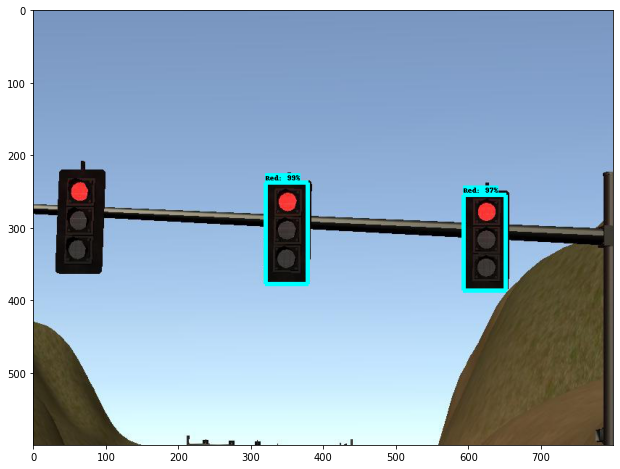

Red 0.99345696
Distance (metres) 0
Time in milliseconds 1178.739070892334 

Red 0.9722718
Distance (metres) 0
Time in milliseconds 1178.739070892334 



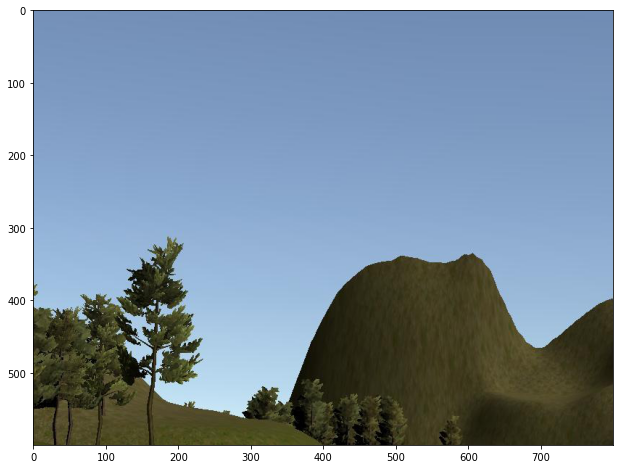

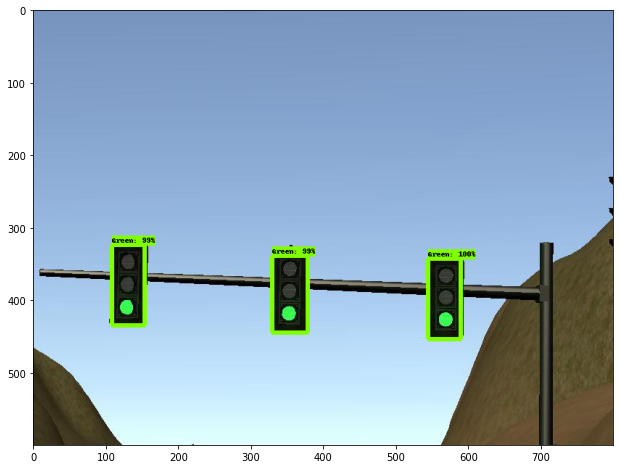

Green 0.99936175
Distance (metres) 0
Time in milliseconds 184.10348892211914 

Green 0.9864114
Distance (metres) 0
Time in milliseconds 184.10348892211914 

Green 0.9856005
Distance (metres) 0
Time in milliseconds 184.10348892211914 



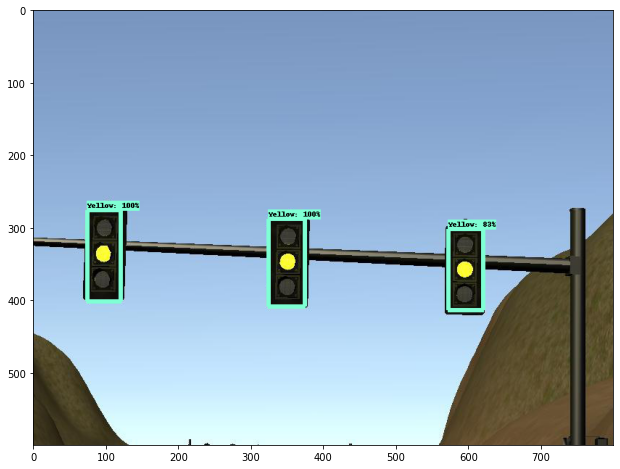

Yellow 0.99594927
Distance (metres) 0
Time in milliseconds 212.48579025268555 

Yellow 0.9956496
Distance (metres) 0
Time in milliseconds 212.48579025268555 

Yellow 0.82756007
Distance (metres) 0
Time in milliseconds 212.48579025268555 



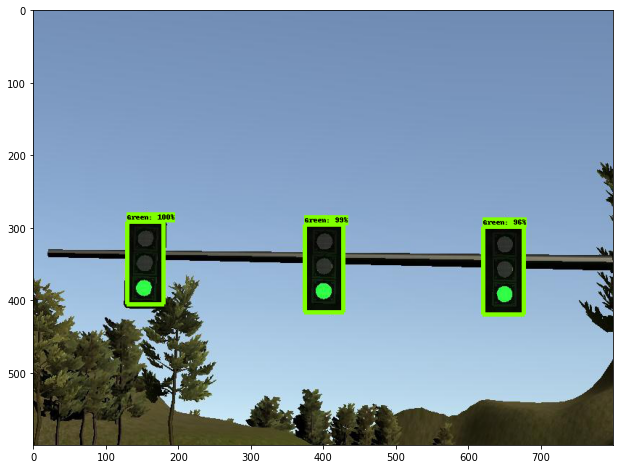

Green 0.99561954
Distance (metres) 0
Time in milliseconds 199.7392177581787 

Green 0.98814297
Distance (metres) 0
Time in milliseconds 199.7392177581787 

Green 0.96469754
Distance (metres) 0
Time in milliseconds 199.7392177581787 



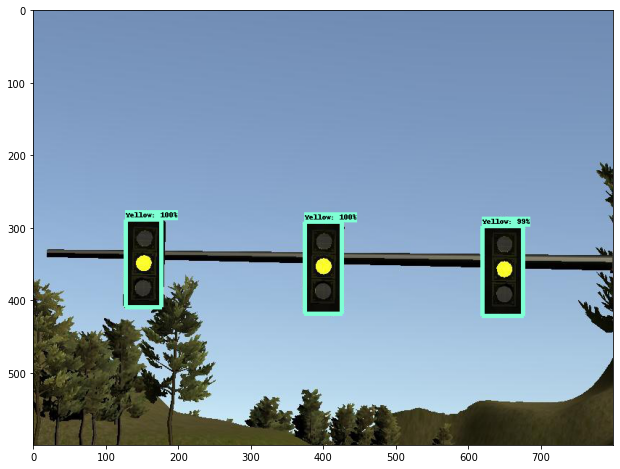

Yellow 0.99962807
Distance (metres) 0
Time in milliseconds 209.2137336730957 

Yellow 0.99938035
Distance (metres) 0
Time in milliseconds 209.2137336730957 

Yellow 0.9905839
Distance (metres) 0
Time in milliseconds 209.2137336730957 



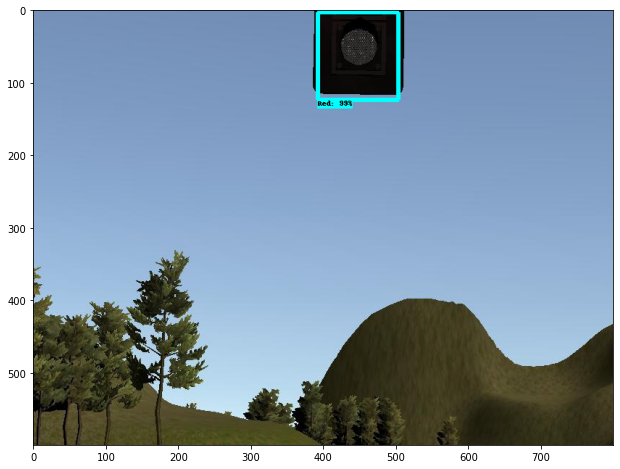

Red 0.98879886
Distance (metres) 0
Time in milliseconds 210.70456504821777 



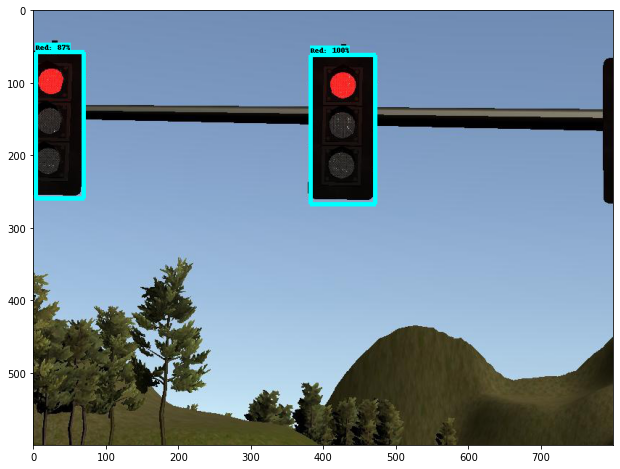

Red 0.9988681
Distance (metres) 0
Time in milliseconds 198.42958450317383 

Red 0.872115
Distance (metres) 0
Time in milliseconds 198.42958450317383 



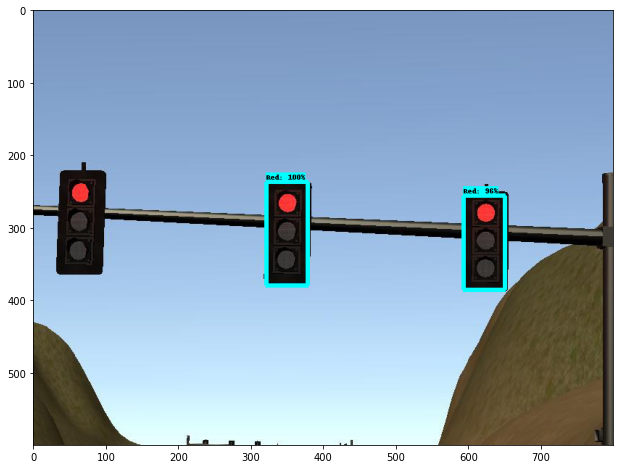

Red 0.9970267
Distance (metres) 0
Time in milliseconds 192.37732887268066 

Red 0.96242166
Distance (metres) 0
Time in milliseconds 192.37732887268066 



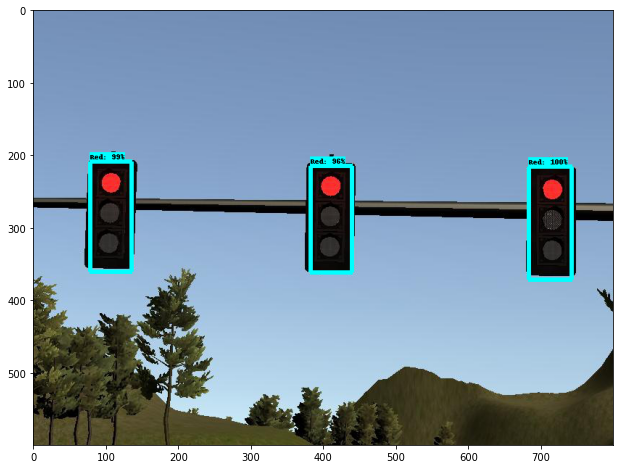

Red 0.99845374
Distance (metres) 0
Time in milliseconds 195.79410552978516 

Red 0.9949022
Distance (metres) 0
Time in milliseconds 195.79410552978516 

Red 0.959664
Distance (metres) 0
Time in milliseconds 195.79410552978516 



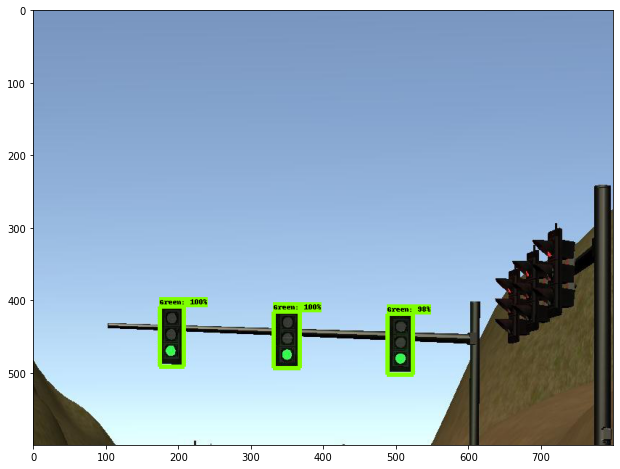

Green 0.99924237
Distance (metres) 0
Time in milliseconds 197.8287696838379 

Green 0.99818534
Distance (metres) 0
Time in milliseconds 197.8287696838379 

Green 0.9771784
Distance (metres) 0
Time in milliseconds 197.8287696838379 



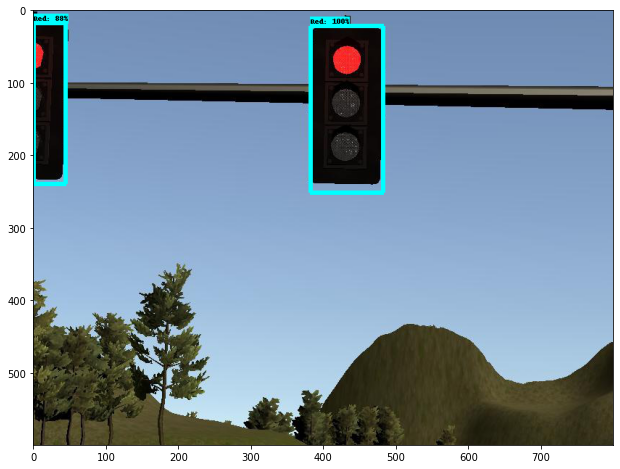

Red 0.99863756
Distance (metres) 0
Time in milliseconds 199.67079162597656 

Red 0.8772113
Distance (metres) 0
Time in milliseconds 199.67079162597656 



In [ ]:
%matplotlib inline
with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
        # Definite input and output Tensors for detection_graph
        image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
        
        # Each box represents a part of the image where a particular object was detected.
        detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
        
        # Each score represent how level of confidence for each of the objects.
        # Score is shown on the result image, together with the class label.
        detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
        detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
        num_detections = detection_graph.get_tensor_by_name('num_detections:0')
        for image_path in TEST_IMAGE_PATHS:
            image = Image.open(image_path)
            # the array based representation of the image will be used later in order to prepare the
            # result image with boxes and labels on it.
            image_np = load_image_into_numpy_array(image)
            # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
            image_np_expanded = np.expand_dims(image_np, axis=0)

            time0 = time.time()

            # Actual detection.
            (boxes, scores, classes, num) = sess.run(
              [detection_boxes, detection_scores, detection_classes, num_detections],
              feed_dict={image_tensor: image_np_expanded})

            time1 = time.time()

            boxes = np.squeeze(boxes)
            scores = np.squeeze(scores)
            classes = np.squeeze(classes).astype(np.int32)
            
            # Visualization of the results of a detection.
            vis_util.visualize_boxes_and_labels_on_image_array(
                image_np, boxes, classes, scores,
                category_index,
                use_normalized_coordinates=True,
                line_thickness=6)
            
            plt.figure(figsize=IMAGE_SIZE)
            plt.imshow(image_np)
            plt.show()

            min_score_thresh = .50
            for i in range(boxes.shape[0]):
                if scores is None or scores[i] > min_score_thresh:

                    class_name = category_index[classes[i]]['name']
                    print('{}'.format(class_name), scores[i])
                    
                    fx =  0.97428
                    fy =  1.73205
                    perceived_width_x = (boxes[i][3] - boxes[i][1]) * 800
                    perceived_width_y = (boxes[i][2] - boxes[i][0]) * 600

                    # ymin, xmin, ymax, xmax = box
                    # depth_prime = (width_real * focal) / perceived_width
                    perceived_depth_x = ((.1 * fx) / perceived_width_x)
                    perceived_depth_y = ((.3 * fy) / perceived_width_y )

                    estimated_distance = round((perceived_depth_x + perceived_depth_y) / 2)
                    print("Distance (metres)", estimated_distance)
                    print("Time in milliseconds", (time1 - time0) * 1000, "\n") 